## TASK 1 - knapsack problem
### Using brute force (BF) and Branch and Bound (BnB) algorithms

Link to git repository: [https://gitlab.fit.cvut.cz/fabosamu/mi-paa-knapsack](https://gitlab.fit.cvut.cz/fabosamu/mi-paa-knapsack)

Knapsack problem is one of the easiest NP-hard problems. It is an *combinatorial optimization* problem.
We are given 

- $n$ - number of items
- $M$ - knapsack capacity
- $V = {v_1, v_2, ..., v_n}$ - weights of items we want to put into knapsack
- $P = {p_1, p_2, ..., p_n}$

Fn the assignment - we need to solve *decisive (0/1)* problem, where we are given non-zero number $C$: 
Is it possible to construct a set $X = {x_1, x_2, ..., x_n}$, where each $x_i$ is 0 or 1, so we will satisfy:

- $v_1x_1 + v_2x_2 + ... + v_nx_n \leq M$ (so that the weight of items do not exceed the capacity of knapsack)
and
- $p_1x_1 + p_2x_2 + ... + p_nx_n \geq C$ (so that the sum of prices for items in knapsack is required to be at least $B$)

\[[1](https://moodle-vyuka.cvut.cz/mod/page/view.php?id=48346)\]

### Brute Force (BF) Algorithm

BF is pretty straightforward - we try each combination of (0/1) vector of length $n$ (as an indicator of appearence of $item_i$ in knapsack) -> so in total we check $2^n$ combinations, which is very exhaustive.

We can cut down some no-go "heavy" states - when expanding the state space, we are cutting down those solutions, which exceed the capacity of the knapsack for granted (we have a lot of heavy items - why do we want to add more if we already exceed capacity?).

In my solution I used recursion. `n, M, weights, prices, max_conf, max_price, visited` we can take as some "global" variables for the problem (some are constants):
```
Brute_knapsack(config: (0/1) vector, i, weight: vector, price: vector):
    if i == n:
        visited ++
        if price >= max_price:
            max_price = price
            max_conf = config
        return

    config[i] = 1
    if Sum(config * weights) <= M:
        Brute_knapsack(conf, i + 1, Sum(config * weights), Sum(config * prices))

    config[i] = 0
    Brute_knapsack(conf, i + 1, Sum(config * weights), Sum(config * prices))
```
After adding an item to knapsack, we check, if it does not exceed capacity - line 10.

### Branch and Bound (BnB) Algorithm

In this algorithm we use so-called cost function - in this case it is the price of added items - to cut down more states needed to visit.

Through recursion calls we keep the best seen solution (`max_price`). In each recursive call we can check if the solution from this "branch" would not be less than the actual one. If so, we cut this subtree and dont dive into it.

In each recursive call we know what to add / not add:
- I know items of which I already made a decision
- I know the actual price of knapsack

The **Upper Bound** we gather as actual `price` + Sum of prices of items, of which I have not decided yet. If this bound is less than the best price obtained, we do not need to call recursively this subtree.

In my BnB algorithm, I first rearange the input so that prices are in descending order and weights are mapped to the same index as price. It is good to have it organized, as we can cut down states even faster - by looking on the items with high price first. To compute the upper bound, I sum the prices of yet unseen items and then compare it with maximal price already obtained. This is shown on lines 10 and 12.

```
Branch_bound(config, i, weight, price):
    if i == n:
        visited ++
        if price >= max_price:
            max_price = price
            max_conf = config
        return

    conf[i] = 1
    upper_bound = Sum(conf * prices) + Sum(prices[i:])

    if (Sum(config * weights) <= M) and (upper_bound >= max_price):
        branch_bound(config, i + 1, Sum(config * weights), Sum(conf * prices))

    conf[i] = 0
    branch_bound(config, i + 1, Sum(config * weights), Sum(conf * prices))
```

Again, `n, M, weights, prices, max_conf, max_price, visited` are constants and global variables.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sys
sys.path.append("..")
from utilities import Problem, branch_bound, brute_knapsack

# helper function for graph bars labeling
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        

### Introduction

I used BnB and BF to solve knapsack problem. Maintenance and overhead around input/output is in the `main.py` file - where I also test the righteousness and optimality of the found witnesses.
Algorithms (both BF and BnB) and helper classes are in `utilities.py` file.
Results are stored in `results` folder, categorized by type of input, algorithm used and number of units for backpack.

These result sets contain information from solution files, where construction problem is solved. 
It comes with the optimal price for each instance and also the optimal vector of (0/1) indicators of appearance in the result set. 

In my result sets, I check if I reached the optimal price (column **status** - witness check) and also if I do not violate the price constraint **C** (column **Passed**). This is the solution of the *decisive problem* as assigned.

### Average number of states visited

First I gather the average of visited states and check if I reached the optimal price every time (I do this also when solving the problems, but - better check twice).

In [2]:
# solvers = ["BB", "brute"]
types = ["N", "Z"]
ns = [4, 10, 15, 20]

results = []

for num in ns:
    for type in types:
        solver = "BB"
        df_BB = pd.read_csv(f"../data/results/{type}R/{solver}/{type}R{num}_out.csv")
        if df_BB.status.unique() != ["OK"]:
            print("FAIL")
        visited_bb = df_BB.visited.mean()
        solver = "brute"
        try:
            df_br = pd.read_csv(f"../data/results/{type}R/{solver}/{type}R{num}_out.csv")
            if df_br.status.unique() != ["OK"]:
                print("FAIL")
            visited_br = df_br.visited.mean()
        except:
            visited_br = np.nan
        
        results.append({"n": num, "type": type, "BnB": visited_bb, "brute": visited_br})

visited = pd.DataFrame(results)
visited

BnB      brute   n type
0      4.406      8.006   4    N
1      6.938     10.422   4    Z
2     29.128    503.862  10    N
3    168.656    762.526  10    Z
4    133.818  16703.760  15    N
5   2481.474  25969.176  15    Z
6    701.302        NaN  20    N
7  36213.550        NaN  20    Z

Here is a visualization of average number of states visited while solving the knapsack problem.

1. "Z" - Zlomyslne (malicious)
1. "N" - Nahodne (random)

*Note: I skipped brute-forcing instances with lenght 20. It took too much time, but the exponential growth of number of states visited is straightforward*



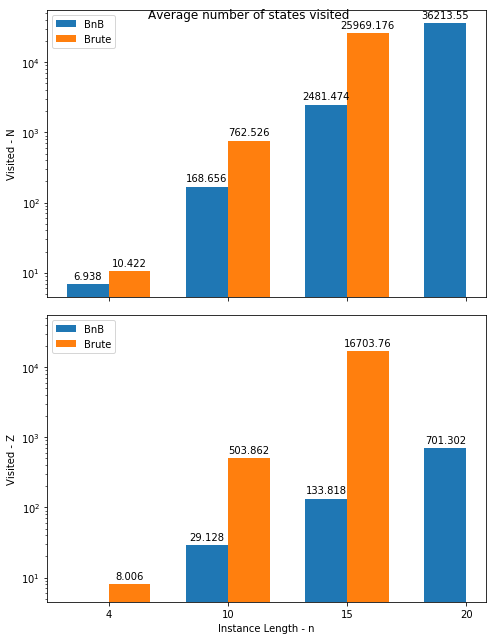

In [3]:
dfm_Z = visited[visited.type == "Z"]
dfm_N = visited[visited.type == "N"]

x = np.arange(len(dfm_Z.n))  # the label locations
width = 0.35  # the width of the bars

fig, (axN, axZ) = plt.subplots(2, sharex=True, sharey=True, figsize=(7,9))
rects1N = axN.bar(x - width/2, dfm_Z.BnB, width, label='BnB')
rects2N = axN.bar(x + width/2, dfm_Z.brute, width, label='Brute')
rects1Z = axZ.bar(x - width/2, dfm_N.BnB, width, label='BnB')
rects2Z = axZ.bar(x + width/2, dfm_N.brute, width, label='Brute')

axN.set_ylabel('Visited - N')
axN.set_xticks(x)
axN.set_xticklabels(dfm_Z.n)
axN.legend()
plt.yscale("log")
axZ.set_ylabel('Visited - Z')
axZ.set_xticks(x)
axZ.set_xticklabels(dfm_N.n)
axZ.legend()
plt.yscale("log")
axZ.set_xlabel("Instance Length - n")
fig.suptitle(f"Average number of states visited")

autolabel(rects1N, axN)
autolabel(rects2N, axN)
autolabel(rects1Z, axZ)
autolabel(rects2Z, axZ)
fig.tight_layout()

From these graphs we can see, how BnB approach improved number of states visited - the time - while solving the problem.

*Note: For some unknown reason, BnB average was not rendered on the second graph for n=4. It is equal to 4.406, as seen in the table above.*

### More informative visualization
Which contains information not only about maximum values (as required).

In [4]:
def get_visited(ns, type, solver):
    res = []
    for num in ns:
        try:
            df = pd.read_csv(f"../data/results/{type}R/{solver}/{type}R{num}_out.csv")
            visited = df.visited.values
        except:
            visited = np.nan
        res.append(visited)
    return res

solvers = ["BB", "brute"]
types = ["N", "Z"]
ns = [4, 10, 15, 20]

n_bb = get_visited(ns, type="N", solver="BB")
n_br = get_visited(ns, type="N", solver="brute")
z_bb = get_visited(ns, type="Z", solver="BB")
z_br = get_visited(ns, type="Z", solver="brute")

/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


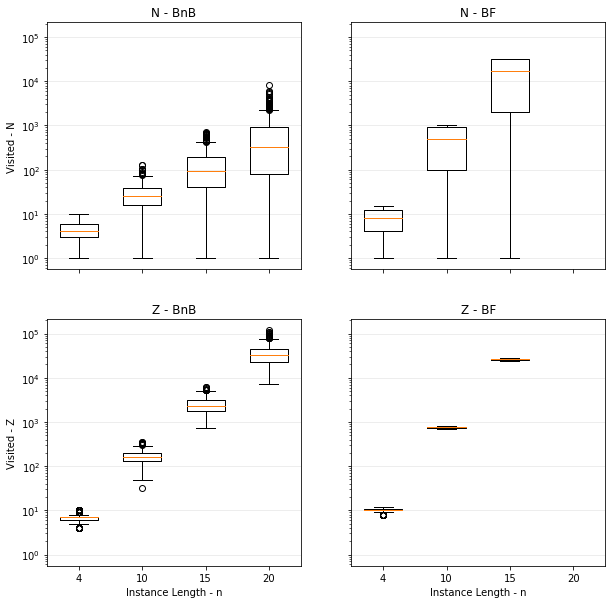

In [5]:
fig, axs = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10,10))
for (x,y), value in np.ndenumerate(axs):
    axs[x,y].yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    
axs[0, 0].boxplot(n_bb, widths = 0.6)
axs[0, 0].set_title('N - BnB')
axs[0, 0].set_ylabel('Visited - N')
axs[0, 1].boxplot(n_br, widths = 0.6)
axs[0, 1].set_title('N - BF')
axs[1, 0].boxplot(z_bb, widths = 0.6)
axs[1, 0].set_title('Z - BnB')
axs[1, 0].set_ylabel('Visited - Z')
axs[1, 0].set_xlabel("Instance Length - n")
axs[1, 1].boxplot(z_br, widths = 0.6)
axs[1, 1].set_title('Z - BF')
axs[1, 1].set_xticklabels(ns)
axs[1, 1].set_xlabel("Instance Length - n")
plt.yscale('log')


plt.show()

In this graph with so-called whiskers we can see the median, both quartiles and outliers as well.  

As expected, randomly generated instances has wider quartiles than specifically picked, malicious instance sets (Z). Not only for BF but also for BnB. Not surprisingly, BF tends to visit more states than BnB, therefore the median is rather closer to higher values.

**My speculation**: BnB is less stable than BF, therefore when given specific malicious inputs, the distribution is a bit wider in comparison with BF - which appears to spend the same amount of time on each instance. 
We also can see most outliers in BnB approach - which, I hope, supports my speculation.

### Histogram

I chose sets with instances of length `n = 10`.

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


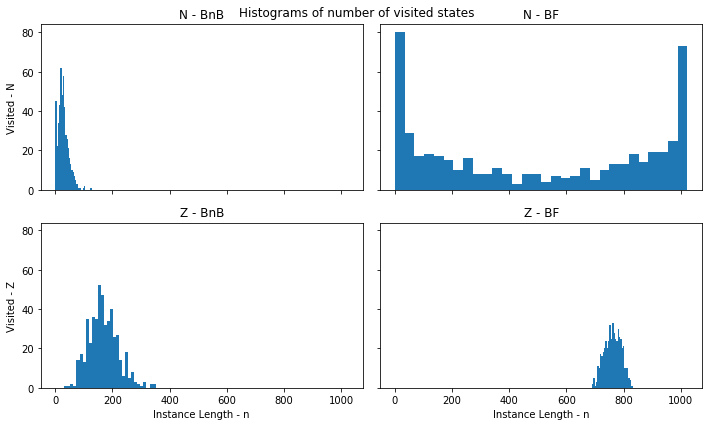

In [6]:
idx = 1
n_bins = 30
fig, axs = plt.subplots(2, 2, sharey=True, sharex=True, tight_layout=True, figsize=(10, 6))

# We can set the number of bins with the `bins` kwarg
axs[0, 0].hist(n_bb[idx], bins=n_bins)
axs[0, 0].set_title('N - BnB')
axs[0, 0].set_ylabel('Visited - N')
axs[0, 1].hist(n_br[idx], bins=n_bins)
axs[0, 1].set_title('N - BF')
axs[1, 0].hist(z_bb[idx], bins=n_bins)
axs[1, 0].set_title('Z - BnB')
axs[1, 0].set_ylabel('Visited - Z')
axs[1, 0].set_xlabel("Instance Length - n")
axs[1, 1].hist(z_br[idx], bins=n_bins)
axs[1, 1].set_title('Z - BF')
axs[1, 1].set_xlabel("Instance Length - n")
plt.suptitle("Histograms of number of visited states")

plt.show()

I set the same x-axis for good reason - we can better see, how these algorithm work on different types of instance set.

BF on randomly generated data (*N - BF*) appears to have U-quadratic (or bimodal) distribution. If I used the dummiest version of BF, it would be a simple uniform distribution - every time we would visit $2^n$ states. 

For me - this is surprising. It is strange that there are that many instances, which - after cutting down no-go "heavy" states - can be solved so fast by BF.
What is not surprising, that it looks like BnB approach takes advantage of this "heavy" states and  gives solution very fast (*N - BnB*). The big peak near zero supports this speculation. 

Not surprisingly - malicious instances (Z) tend to make computational time as high as possible. 
But it sometimes misses (I suppose these sets were created by smart people - but still humans). 
Therefore we can see something similar to skewed normal distribution both in *Z - BnB* and *Z - BF* approaches.
Of course - BnB is still faster.

### CPU runtime measurements
**Hypothesis**: I see that the number of visited nodes using branch and bound algorithm is lower. Now I would like to make an experiment, where I want to show that this method is really faster than the brute force approach.

I randomly choose `k` instances from each of the instance file, use BF and BnB algorithm 10 times for each instance and take the mean of the measurement as an approximation of CPU runtime.

I ran this measurements on a MacBook Pro machine:
- Processor: 2,5 GHz Dual-Core Intel Core i7
- Memory: 16 GB 2133 MHz LPDDR3

*Note: uncomment, if you want to rerun all the runtime measurements. Saved in folder `time`*

In [7]:
k = 25

In [8]:
# for num in [4, 10, 15, 20]:
#     for type in ["N", "Z"]:
#         inst_lines = [line.rstrip('\n') for line in open(f"../data/{type}R/{type}R{num}_inst.dat")]
#         samples = random.choices(inst_lines, k=k)
#         times = list()
#         for sample in samples:
#             inst = list(map(int, sample.split()))
#             p = Problem(-inst[0], inst[1], inst[2], inst[3], np.array(inst[4::2]), np.array(inst[5::2]), sorted=True)
# 
#             t = %timeit -oq -n 10 branch_bound(p, p.max_conf, 0, 0, 0)
#             t_BnB = np.mean(t.all_runs)
# 
#             t = %timeit -oq -n 10 brute_knapsack(p, p.max_conf, 0, 0, 0)
#             t_brute = np.mean(t.all_runs)
#             # t_brute = np.nan
# 
#             res = {"ID": p.ID, "brute": t_brute, "BnB": t_BnB}
#             times.append(res)
#             print(p.ID, res)
# 
#         dft = pd.DataFrame(times)
#         print("=" * 50, num, type)
#         dft.to_csv(f"../data/time/{type}R/{type}R{num}_time.csv")

Gathering and plotting time measurements from files in `time` folder.

In [9]:
mean_results = list()
type = "Z"
for num in [4, 10, 15, 20]:
    for type in ["N", "Z"]:
        dft = pd.read_csv(f"../data/time/{type}R/{type}R{num}_time.csv")
        mean_results.append({"n": num, "type": type, "BnB": dft.BnB.mean(), "brute": dft.brute.mean()})

dfm = pd.DataFrame(mean_results)
dfm = dfm.round(4)
dfm_Z = dfm[dfm.type == "Z"]
dfm_N = dfm[dfm.type == "N"]

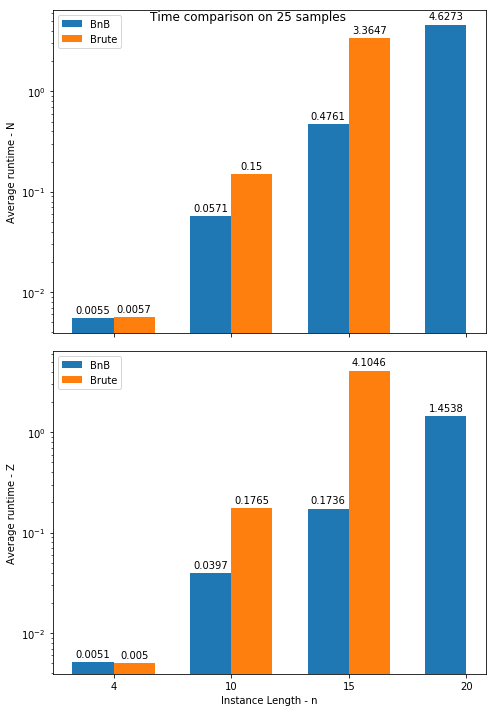

In [10]:
x = np.arange(len(dfm_Z.n))  # the label locations
width = 0.35  # the width of the bars

fig, (axN, axZ) = plt.subplots(2, sharex=True, sharey=True, figsize=(7,10))
rects1N = axN.bar(x - width/2, dfm_Z.BnB, width, label='BnB')
rects2N = axN.bar(x + width/2, dfm_Z.brute, width, label='Brute')
rects1Z = axZ.bar(x - width/2, dfm_N.BnB, width, label='BnB')
rects2Z = axZ.bar(x + width/2, dfm_N.brute, width, label='Brute')

axN.set_ylabel('Average runtime - N')
axN.set_xticks(x)
axN.set_xticklabels(dfm_Z.n)
axN.legend()
plt.yscale("log")
axZ.set_ylabel('Average runtime - Z')
axZ.set_xticks(x)
axZ.set_xticklabels(dfm_N.n)
axZ.legend()
plt.yscale("log")
axZ.set_xlabel("Instance Length - n")
fig.suptitle(f"Time comparison on {k} samples")

autolabel(rects1N, axN)
autolabel(rects2N, axN)
autolabel(rects1Z, axZ)
autolabel(rects2Z, axZ)
fig.tight_layout()


As we can see, the time spent on each instance grows exponentially with the growing number of items for the backpack (higher n).
Both algorithms has exponential complexity, as expected (and noted in the assignment). 

### Conclusion

1. Výpočetní složitost (čas) budete měřit počtem navštívených konfigurací, to jest vyhodnocených sestav věcí v batohu.
- Done, I counted number of visited states both for BF and BnB algorithm.

2. Na obou sadách pozorujte závislost výpočetního času na n, pro n v rozsahu, jaký je Vaše výpočetní platforma schopna zvládnout, a to jak maximální, tak průměrný čas. 
- I showed, how with higher *n* the number of visited states is rising. Also I made an experiment, where it is showed in the same way.

3. Pro alespoň jednu hodnotu n zjistěte četnosti jednotlivých hodnot (histogram) a pokuste se jej vysvětlit.
- For $n=10$ I made a visualization of histograms for both instance sets and for both algorithms.

4. Metodu větví a hranic použijte tak, aby omezujícím faktorem byla hodnota optimalizačního kritéria. Tj. použijte ořezávání shora (překročení kapacity batohu) i zdola (stávající řešení nemůže být lepší než nejlepší dosud nalezené).
- This can be seen in the source code - `utilities.py` file.